In [1]:
# To print multiple output in a cell
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

In [2]:
# Import all required libraries
import pandas as pd # Data manipulation and analysis library
from statsmodels.tsa.seasonal import seasonal_decompose # Seasonal decomposition to check seasonality
from sklearn.feature_selection import RFE # RFE (Recursive Feature Elimination) is for feature selection
from sklearn.ensemble import RandomForestRegressor # Random forest modelling
import numpy as np # For arrays and mathematical operations
from statsmodels.tsa.stattools import adfuller # Dickey-fuller testto check stationarity of data
from sklearn.metrics import mean_squared_error # For evaluating the model
from sklearn.preprocessing import LabelEncoder # To encode categorical integer features
import matplotlib.pyplot as plt # For plotting
import seaborn as sns # Statistical data visualization
import scipy.stats as stats # Statistical analysis
import pylab # For plotting
import warnings # To handle warnings
warnings.filterwarnings("ignore") # Ignore all warings
from statsmodels.tsa.statespace.sarimax import SARIMAX # To do SARIMAX
from sklearn.model_selection import train_test_split # To split into train and test data set
from sklearn.preprocessing import StandardScaler # For RNN: Recursive neural network
from keras.models import Sequential # For RNN
from keras.layers import LSTM, Dense, Dropout # For RNN
from keras.optimizers import Adam # For RNN

In [3]:
# Ignore all warings
warnings.filterwarnings("ignore")

In [4]:
# Import data
file_path = 'C:\\Users\\SiddharthaPaul\\OneDrive - Tata Business Hub Limited\\Desktop\\Hackathon'
date_format = "%d/%m/%y"
df = pd.read_csv(file_path+'\\train.csv', sep = ',', parse_dates = ['week'], date_parser = lambda x: pd.to_datetime(x, format = date_format))

In [5]:
# Characteristics of data
df.head()
df.shape
df.info()

,record_ID,week,store_id,sku_id,total_price,base_price,is_featured_sku,is_display_sku,units_sold
0,1,2011-01-17,8091,216418,99.0375,111.8625,0,0,20
1,2,2011-01-17,8091,216419,99.0375,99.0375,0,0,28
2,3,2011-01-17,8091,216425,133.9500,133.9500,0,0,19
3,4,2011-01-17,8091,216233,133.9500,133.9500,0,0,44
4,5,2011-01-17,8091,217390,141.0750,141.0750,0,0,52


(150150, 9)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150150 entries, 0 to 150149
Data columns (total 9 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   record_ID        150150 non-null  int64         
 1   week             150150 non-null  datetime64[ns]
 2   store_id         150150 non-null  int64         
 3   sku_id           150150 non-null  int64         
 4   total_price      150149 non-null  float64       
 5   base_price       150150 non-null  float64       
 6   is_featured_sku  150150 non-null  int64         
 7   is_display_sku   150150 non-null  int64         
 8   units_sold       150150 non-null  int64         
dtypes: datetime64[ns](1), float64(2), int64(6)
memory usage: 10.3 MB


In [6]:
df['week'].max()

Timestamp('2013-07-09 00:00:00')

In [7]:
df['week'].min()

Timestamp('2011-01-17 00:00:00')

In [8]:
# Check null values in the data
df.isnull().sum()

record_ID          0
week               0
store_id           0
sku_id             0
total_price        1
base_price         0
is_featured_sku    0
is_display_sku     0
units_sold         0
dtype: int64

In [9]:
# Since total no. of rows = 150150 and the null value is only in 1 row, therefore, we will remove the null row
# Calculate the total number of rows
total_rows = len(df)
# Calculate the number of rows with missing values
na_rows = df.isna().any(axis=1).sum()
if na_rows < total_rows * 0.01:
    df.dropna(inplace=True)
else:
    # Fill missing values with the average of store_id and sku_id combination
    df.fillna(df.groupby(['store_id', 'sku_id']).transform('mean'), inplace=True)
df.isnull().sum()

record_ID          0
week               0
store_id           0
sku_id             0
total_price        0
base_price         0
is_featured_sku    0
is_display_sku     0
units_sold         0
dtype: int64

In [10]:
# Checking whether there are rows where the total_price or units_sold <=0
df.shape
df['total_price'].loc[df['total_price']<=0].count()
df['units_sold'].loc[df['units_sold']<=0].count()

(150149, 9)

0

0

In [11]:
# Delete rows with negative rows
con1 = df['units_sold']<=0
con2 = df['total_price']<=0
df = df[~(con1 & con2)]
df.shape

(150149, 9)

In [12]:
# Dropping duplicates if any
df.shape
df = df.drop_duplicates(['week', 'store_id', 'sku_id'])
df.shape

(150149, 9)

(150149, 9)

In [13]:
# Sort dataframe by date column in chronological order
df = df.sort_values(by='week', ascending=False)
df.head()

,record_ID,week,store_id,sku_id,total_price,base_price,is_featured_sku,is_display_sku,units_sold
150149,212644,2013-07-09,9984,679023,234.4125,234.4125,0,0,15
149427,211610,2013-07-09,9164,378934,213.0375,213.0375,0,0,16
149375,211530,2013-07-09,9112,216418,110.4375,110.4375,0,0,162
149376,211531,2013-07-09,9112,216419,109.7250,109.7250,0,0,137
149377,211532,2013-07-09,9112,300021,109.0125,109.0125,0,0,108


In [14]:
# Function to create data frame for the selected store_id and sku_id
def create_dataframe(sku_id, df):
    # Filter the data for the specified store_id and sku_id
    filtered_data = df[(df['sku_id'] == sku_id)]

    # If no data is found for the specified sku_id, return None
    if filtered_data.empty:
        print("No data found for the specified sku_id.")
        return None

    return filtered_data

In [15]:
# Get user input for sku_id
#sku_id = int(input("Enter sku_id: "))
sku_id=216425

In [16]:
# Call the function with user inputs to create dataframe of selected store_id and sku_id
df_selected = create_dataframe(sku_id,df)
if df_selected is not None:
    df_selected.head()
    df_selected.shape

,record_ID,week,store_id,sku_id,total_price,base_price,is_featured_sku,is_display_sku,units_sold
149378,211535,2013-07-09,9112,216425,141.7875,141.7875,0,0,72
149358,211511,2013-07-09,9092,216425,129.6750,129.6750,0,0,18
149420,211602,2013-07-09,9164,216425,141.0750,141.0750,0,0,44
149394,211560,2013-07-09,9132,216425,131.8125,131.8125,0,0,13
149406,211580,2013-07-09,9147,216425,133.2375,133.2375,0,0,61


(8580, 9)

In [17]:
#df_selected = df_selected.drop(columns=['record_ID', 'store_id'])

In [18]:
df_selected.head()

,record_ID,week,store_id,sku_id,total_price,base_price,is_featured_sku,is_display_sku,units_sold
149378,211535,2013-07-09,9112,216425,141.7875,141.7875,0,0,72
149358,211511,2013-07-09,9092,216425,129.6750,129.6750,0,0,18
149420,211602,2013-07-09,9164,216425,141.0750,141.0750,0,0,44
149394,211560,2013-07-09,9132,216425,131.8125,131.8125,0,0,13
149406,211580,2013-07-09,9147,216425,133.2375,133.2375,0,0,61


In [19]:
# Group by sku_id and week and perform aggregation
#df_selected = df.groupby(['sku_id','week']).agg({
#    'total_price': 'mean',
#    'base_price': 'mean',
#    'is_featured_sku': 'max',
#    'is_display_sku': 'max',
#    'units_sold': 'sum'
#}).reset_index()

# Print the aggregated DataFrame
#print(df_selected)

In [20]:
# Pre-processing the data
def preprocess_data(df):
    # Convert 'week' column to datetime type and extract seasonality features
    df['week'] = pd.to_datetime(df['week'])
    df['month'] = df['week'].dt.month
    df['year'] = df['week'].dt.year
    df['day_of_week'] = df['week'].dt.dayofweek
    df['day_of_month'] = df['week'].dt.day
    df['discount'] = df['base_price'] - df['total_price']
    # Encode categorical variables 'is_featured_sku' and 'is_display_sku'
    label_encoder = LabelEncoder()
    df['is_featured_sku'] = label_encoder.fit_transform(df['is_featured_sku'])
    df['is_display_sku'] = label_encoder.fit_transform(df['is_display_sku'])
    
    return df

In [21]:
# Call the function to pre-process the data
df_processed = preprocess_data(df_selected)

In [22]:
df_processed.head()

,record_ID,week,store_id,sku_id,total_price,base_price,is_featured_sku,is_display_sku,units_sold,month,year,day_of_week,day_of_month,discount
149378,211535,2013-07-09,9112,216425,141.7875,141.7875,0,0,72,7,2013,1,9,0.0
149358,211511,2013-07-09,9092,216425,129.6750,129.6750,0,0,18,7,2013,1,9,0.0
149420,211602,2013-07-09,9164,216425,141.0750,141.0750,0,0,44,7,2013,1,9,0.0
149394,211560,2013-07-09,9132,216425,131.8125,131.8125,0,0,13,7,2013,1,9,0.0
149406,211580,2013-07-09,9147,216425,133.2375,133.2375,0,0,61,7,2013,1,9,0.0


In [23]:
#df_processed.drop(['week'], inplace=True, axis = 1)

In [24]:
df_processed.head()

,record_ID,week,store_id,sku_id,total_price,base_price,is_featured_sku,is_display_sku,units_sold,month,year,day_of_week,day_of_month,discount
149378,211535,2013-07-09,9112,216425,141.7875,141.7875,0,0,72,7,2013,1,9,0.0
149358,211511,2013-07-09,9092,216425,129.6750,129.6750,0,0,18,7,2013,1,9,0.0
149420,211602,2013-07-09,9164,216425,141.0750,141.0750,0,0,44,7,2013,1,9,0.0
149394,211560,2013-07-09,9132,216425,131.8125,131.8125,0,0,13,7,2013,1,9,0.0
149406,211580,2013-07-09,9147,216425,133.2375,133.2375,0,0,61,7,2013,1,9,0.0


In [25]:
# Check if the data is stationary
result = adfuller(df_processed['units_sold'].dropna())
# Print the test statistic and p-value
print('ADF Statistic:', result[0])
print('p-value:', result[1])

ADF Statistic: -7.585355344646755
p-value: 2.6155227314869616e-11


In [26]:
# Since the p-value is below 0.05,
# the data can be assumed to be stationary hence we can proceed with the data without any transformation.

In [27]:
df_processed.shape

(8580, 14)

In [28]:
df_processed['units_sold'].skew()

1.4209199486838835

In [29]:
# units sold is highly positively skewed since skewness > 1

<Axes: >

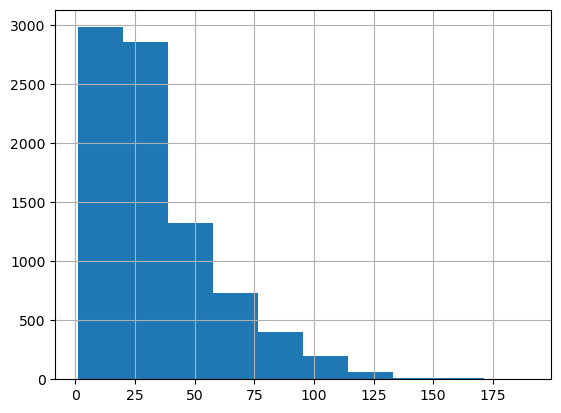

In [30]:
df_processed.units_sold.hist()

<Axes: xlabel='units_sold', ylabel='Density'>

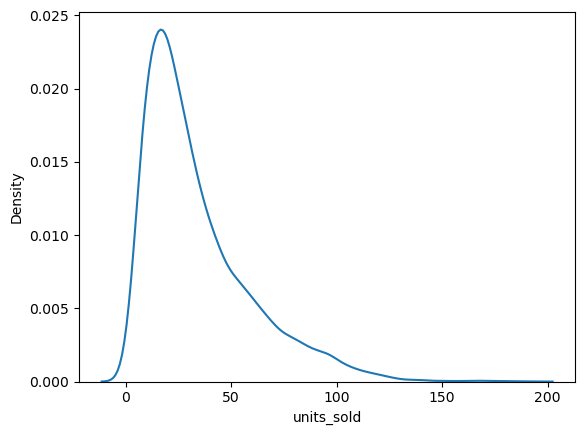

In [31]:
sns.kdeplot(df_processed.units_sold)

<Figure size 1600x500 with 0 Axes>

<Axes: >

<Axes: xlabel='units_sold', ylabel='Density'>

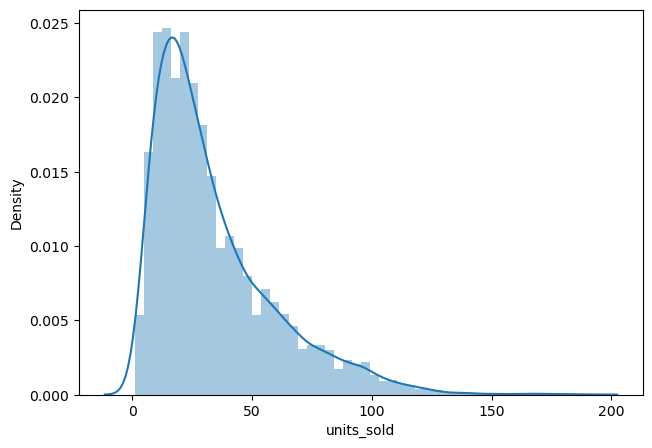

In [32]:
plt.figure(figsize=(16,5))
plt.subplot(1,2,1)
sns.distplot(df_processed['units_sold'])
plt.show()

((array([-3.77258292, -3.54529463, -3.42041149, ...,  3.42041149,
          3.54529463,  3.77258292]),
  array([  1,   1,   1, ..., 177, 181, 190], dtype=int64)),
 (23.691646652457017, 34.01923076923076, 0.93590491608157))

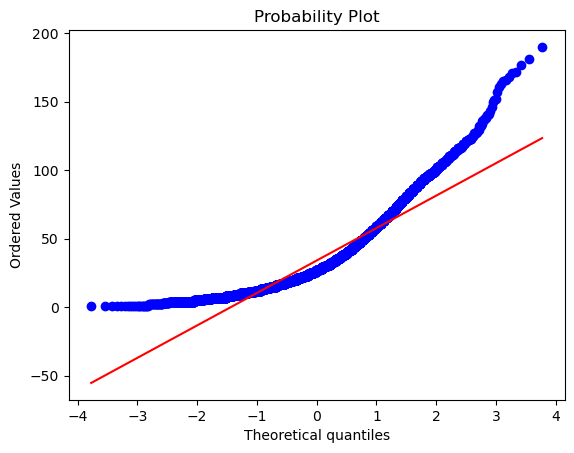

In [33]:
# Q-Q plot
stats.probplot(df_processed.units_sold, plot = pylab)

In [34]:
# Tail of the data
df_processed.loc[df_processed['store_id']==8091].tail()

,record_ID,week,store_id,sku_id,total_price,base_price,is_featured_sku,is_display_sku,units_sold,month,year,day_of_week,day_of_month,discount
4622,6555,2011-02-14,8091,216425,133.2375,133.2375,0,0,23,2,2011,0,14,0.0
3467,4915,2011-02-07,8091,216425,133.9500,133.9500,0,0,18,2,2011,0,7,0.0
2312,3279,2011-01-31,8091,216425,133.2375,133.2375,0,0,27,1,2011,0,31,0.0
1157,1643,2011-01-24,8091,216425,134.6625,134.6625,0,0,17,1,2011,0,24,0.0
2,3,2011-01-17,8091,216425,133.9500,133.9500,0,0,19,1,2011,0,17,0.0


In [35]:
# Logarithmic transformation of data
df_processed['units_sold'] = np.log(df_processed['units_sold'])

In [36]:
# Tail of the data
df_processed.loc[df_processed['store_id']==8091].tail()

,record_ID,week,store_id,sku_id,total_price,base_price,is_featured_sku,is_display_sku,units_sold,month,year,day_of_week,day_of_month,discount
4622,6555,2011-02-14,8091,216425,133.2375,133.2375,0,0,3.135494,2,2011,0,14,0.0
3467,4915,2011-02-07,8091,216425,133.9500,133.9500,0,0,2.890372,2,2011,0,7,0.0
2312,3279,2011-01-31,8091,216425,133.2375,133.2375,0,0,3.295837,1,2011,0,31,0.0
1157,1643,2011-01-24,8091,216425,134.6625,134.6625,0,0,2.833213,1,2011,0,24,0.0
2,3,2011-01-17,8091,216425,133.9500,133.9500,0,0,2.944439,1,2011,0,17,0.0


In [37]:
df_processed['units_sold'].skew()

-0.39976022280938533

<Figure size 1600x500 with 0 Axes>

<Axes: >

<Axes: xlabel='units_sold', ylabel='Density'>

<Axes: >

((array([-3.77258292, -3.54529463, -3.42041149, ...,  3.42041149,
          3.54529463,  3.77258292]),
  array([0.        , 0.        , 0.        , ..., 5.17614973, 5.19849703,
         5.24702407])),
 (0.7757181233425725, 3.2518085888101997, 0.9938156688996619))

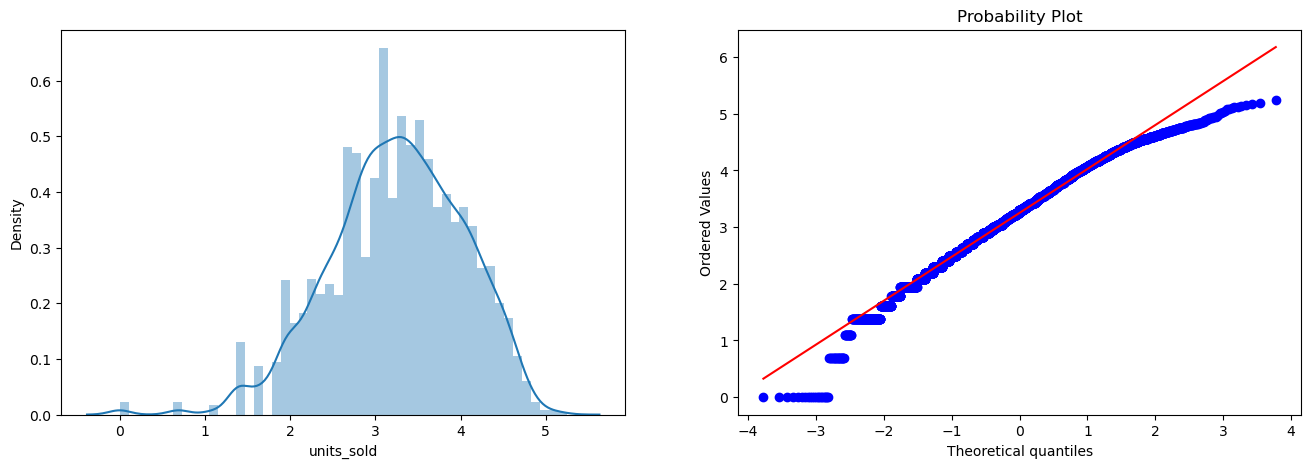

In [38]:
plt.figure(figsize=(16,5))
plt.subplot(1,2,1)
sns.distplot(df_processed['units_sold'])
plt.subplot(1,2,2)
stats.probplot(df_processed['units_sold'], plot = pylab)
plt.show()

In [39]:
# Finding the boundary values
UL = df_processed['units_sold'].mean() + 3*df_processed['units_sold'].std()
LL = df_processed['units_sold'].mean() - 3*df_processed['units_sold'].std()
UL
LL

5.5926190436046035

0.9109981340157955

In [40]:
df_processed.shape

(8580, 14)

In [41]:
df_processed['units_sold'].loc[df_processed['units_sold']<LL].count()

42

In [42]:
df_processed['units_sold'].loc[df_processed['units_sold']>UL].count()

0

In [43]:
# Removing outliers
condition1 = df_processed['units_sold']>UL
condition2 = df_processed['units_sold']<LL
df_processed = df_processed[~(condition1 & condition2)]

In [44]:
# Seasonal decompose
df_processed.head()

,record_ID,week,store_id,sku_id,total_price,base_price,is_featured_sku,is_display_sku,units_sold,month,year,day_of_week,day_of_month,discount
149378,211535,2013-07-09,9112,216425,141.7875,141.7875,0,0,4.276666,7,2013,1,9,0.0
149358,211511,2013-07-09,9092,216425,129.6750,129.6750,0,0,2.890372,7,2013,1,9,0.0
149420,211602,2013-07-09,9164,216425,141.0750,141.0750,0,0,3.784190,7,2013,1,9,0.0
149394,211560,2013-07-09,9132,216425,131.8125,131.8125,0,0,2.564949,7,2013,1,9,0.0
149406,211580,2013-07-09,9147,216425,133.2375,133.2375,0,0,4.110874,7,2013,1,9,0.0


In [45]:
# Pre-processing for seasonal decompose
df_seasonal_decompose = df_processed
df_seasonal_decompose['week'] = pd.to_datetime(df_seasonal_decompose['week'])
df_seasonal_decompose = df_seasonal_decompose.set_index('week')
store_id=8091
df_seasonal_decompose = df_seasonal_decompose[df_seasonal_decompose['store_id'] == store_id]

In [46]:
# Seasonal decomposition
result_seasonal_decompose = seasonal_decompose(df_seasonal_decompose['units_sold'], model='additive', period=52)  # Assuming weekly seasonality

<Figure size 1200x800 with 0 Axes>

<Axes: >

<Axes: >

<Axes: >

<Axes: >

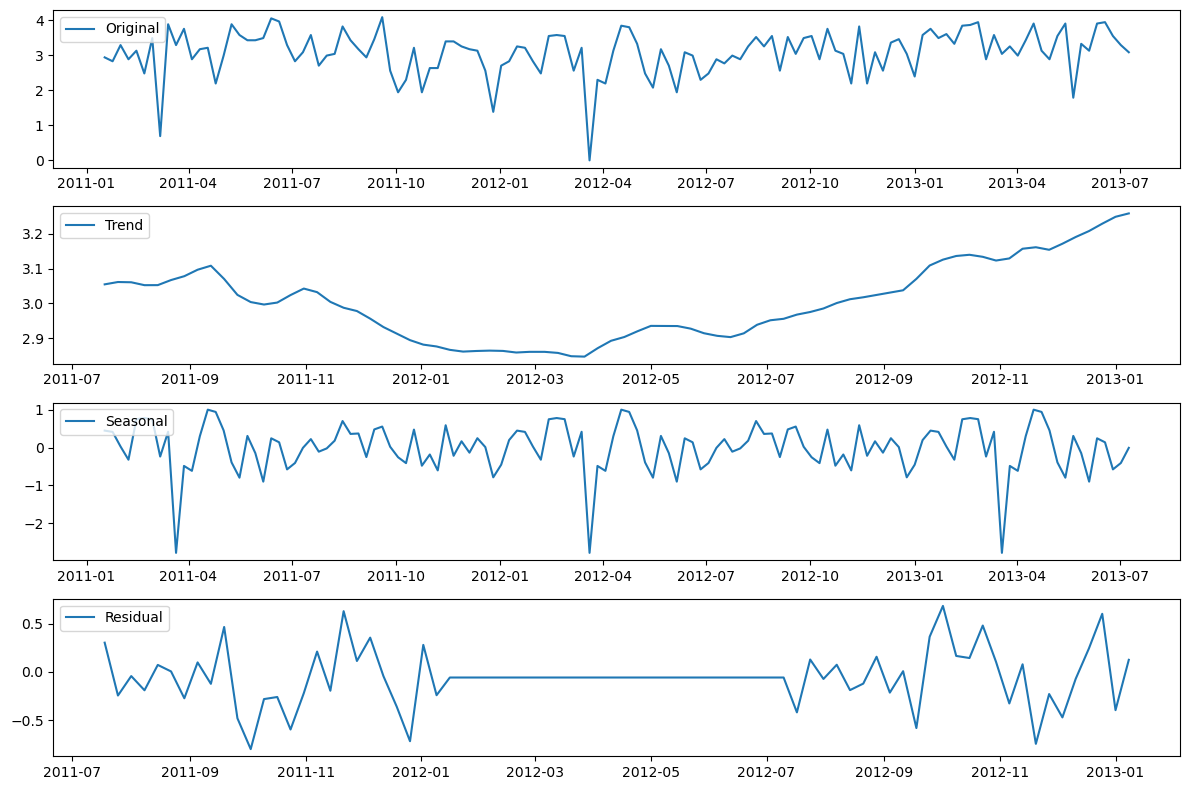

In [47]:
# Plot the decomposition
plt.figure(figsize=(12, 8))
plt.subplot(411)
plt.plot(df_seasonal_decompose['units_sold'], label='Original')
plt.legend(loc='upper left')
plt.subplot(412)
plt.plot(result_seasonal_decompose.trend, label='Trend')
plt.legend(loc='upper left')
plt.subplot(413)
plt.plot(result_seasonal_decompose.seasonal, label='Seasonal')
plt.legend(loc='upper left')
plt.subplot(414)
plt.plot(result_seasonal_decompose.resid, label='Residual')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

In [48]:
# Calculate metrics
trend_mean = result.trend.mean()  # Mean of the trend component
seasonal_mean = result.seasonal.mean()  # Mean of the seasonal component
residual_std = result.resid.std()  # Standard deviation of the residual component

# Print insights
print("Insights from Seasonal Decomposition:")
print(f"Mean of Trend Component: {trend_mean}")
print(f"Mean of Seasonal Component: {seasonal_mean}")
print(f"Standard Deviation of Residual Component: {residual_std}")

AttributeError: 'tuple' object has no attribute 'trend'

In [ ]:
# Calculate the number of rows for testing
test_size = int(len(df_processed)*0.2)
end_point = len(df_processed)
x = end_point - test_size

In [ ]:
df_processed.shape
test_size
end_point
x

In [ ]:
# Split into train and test
df_processed_train = df_processed.iloc[:x - 1]
df_processed_test = df_processed.iloc[x:]

In [ ]:
# Check shape of test and train
df_processed_train.shape
df_processed_test.shape

In [ ]:
# Processed data
df_processed_train.head()
df_processed_test.head()

In [ ]:
X_test = df_processed_test.loc[:, df_processed_test.columns != 'units_sold']
y_test = df_processed_test[['units_sold']]
X_train = df_processed_train.loc[:, df_processed_train.columns != 'units_sold']
y_train = df_processed_train[['units_sold']]

In [ ]:
X_test.head()
y_test.head()
X_train.head()
y_train.head()

In [ ]:
X_test.reset_index(drop=True, inplace=True)
y_test.reset_index(drop=True, inplace=True)
X_train.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True)

In [ ]:
X_test_sarimax = X_test
y_test_sarimax = y_test
X_train_sarimax = X_train
y_train_sarimax = y_train

In [ ]:
X_test.head()
y_test.head()
X_train.head()
y_train.head()

In [ ]:
type(y_test)

In [ ]:
type(X_test)

In [ ]:
X_test.set_index('week', inplace=True)
X_train.set_index('week', inplace=True)

In [ ]:
def train_random_forest(X_train, y_train):
    # Creating a Random Forest regressor
    #rf_regressor = RandomForestRegressor(n_estimators=100, random_state=42)

    # Training the model
    #rf_regressor.fit(X_train, y_train)

    # Making predictions on the testing set
    rf_regressor = RandomForestRegressor(n_estimators=100, random_state=42)
    rf_regressor = RFE(estimator = rf_regressor, n_features_to_select=7)
    fit = rf_regressor.fit(X_train, y_train)
    y_pred = fit.predict(X_test)
    selected_features = X_train.columns[rf_regressor.support_]
    print("Selected Features:",selected_features)
    
    return y_pred, fit

In [ ]:
y_pred, fit = train_random_forest(X_train,y_train)

In [ ]:
y_pred

In [ ]:
#Evaluate accuracy using MAPE
y_true = np.array(y_test['units_sold'])
sumvalue=np.sum(y_true)
mape=np.sum(np.abs((y_true - y_pred)))/sumvalue*100
accuracy=100-mape
print('Accuracy:', round(accuracy,2),'%.')

In [ ]:
# Find RMSE
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
print("RMSE:",rmse)
print("MSE:",mse)

In [ ]:
def plot_predictions(y_test, y_pred):
    plt.figure(figsize=(10, 6))
    plt.scatter(y_test, y_pred, color='blue')
    plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')
    plt.xlabel('Actual units_sold')
    plt.ylabel('Predicted units_sold')
    plt.title('Actual vs. Predicted units_sold')
    plt.show()

In [ ]:
y_test1 = y_test.values.flatten()

In [ ]:
y_test1

In [ ]:
comp = pd.DataFrame(data=[y_test1,y_pred]).T
comp.columns=['y_test','y_pred']

In [ ]:
comp

In [ ]:
plot_predictions(y_test1, y_pred)

In [ ]:
plt.plot (y_test1)

In [ ]:
plt.plot (y_pred)

In [ ]:
# Calculation of safety stock factor
def calculate_safety_factor(desired_service_level, standard_deviation):
    # Calculation Z-score corresponding to the desired service level
    z_score = stats.norm.ppf(desired_service_level)
    
    #Calculate safety factor
    safety_factor = z_score * standard_deviation
    
    return safety_factor

In [ ]:
# Get desired service level
#desired_service_level = float(input("Enter desired service level (ex: 0.95 for 95%): "))
desired_service_level = 0.9

In [ ]:
# Calculation of standard_deviation
filtered_df = df_processed[(df['store_id'] == store_id) & (df_processed['sku_id'] == sku_id)]
standard_deviation = filtered_df['units_sold'].std()

In [ ]:
# Calculation of re-order point
def calculate_reorder_point (demand_forecast, lead_time, safety_factor):
    average_demand = np.mean(demand_forecast)
    demand_std = np.std(demand_forecast)
    safety_stock = safety_factor * demand_std
    safety_stock = safety_stock.round()
    reorder_point = average_demand * lead_time + safety_stock
    reorder_point = reorder_point.round()
    return reorder_point, safety_stock

In [ ]:
# Get user input for sku_id
#lead_time = int(input("Enter lead time in weeks: "))
lead_time = 2

In [ ]:
X_test.shape
y_test.shape

In [ ]:
X_test.head()
y_test.head()

In [ ]:
X_test.reset_index(drop=True, inplace=True)
test_df = pd.concat([X_test, y_test], axis=1)
test_df.head()

In [ ]:
#test_df['units_sold'] = np.exp(df['units_sold'])
test_df.tail()

In [ ]:
test_df['units_sold'] = np.exp(test_df['units_sold'])
test_df.tail()

In [ ]:
demand_forecast = test_df[(df['store_id'] == store_id) & (df_processed['sku_id'] == sku_id)]
demand_forecast.head()

In [ ]:
demand_forecast = demand_forecast['units_sold']
demand_forecast.head()

In [ ]:
demand_forecast = demand_forecast.values

In [ ]:
safety_factor = calculate_safety_factor(desired_service_level, standard_deviation)
reorder_point = calculate_reorder_point (demand_forecast, lead_time, safety_factor)

In [ ]:
reorder_point

In [ ]:
# Starting RNN (Recurrent Neural Network)
df_nrr = df_processed
df_nrr.head()

In [ ]:
# Drop unnecessary columns
df_nrr = df_nrr.drop(columns=['record_ID', 'week'])  # Drop unnecessary columns

In [ ]:
# Normalize numerical features
scaler = StandardScaler()
df_nrr[['total_price', 'base_price']] = scaler.fit_transform(df_nrr[['total_price', 'base_price']])

In [ ]:
df_nrr.head()

In [ ]:
# Split data into features (X) and target (y)
X_nrr = df_nrr.drop(columns=['units_sold'])
y_nrr = df_nrr['units_sold']

In [ ]:
# Split data into training and testing sets
X_nrr_train, X_nrr_test, y_nrr_train, y_nrr_test = train_test_split(X_nrr, y_nrr, test_size=0.2, random_state=42)

In [ ]:
# Reshape input data for LSTM
X_nrr_train = np.array(X_nrr_train).reshape(X_nrr_train.shape[0], X_nrr_train.shape[1], 1)
X_nrr_test = np.array(X_nrr_test).reshape(X_nrr_test.shape[0], X_nrr_test.shape[1], 1)

In [ ]:
y_nrr.head()

In [ ]:
#X_nrr.head()

In [ ]:
# Define the RNN model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_nrr_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(units=1))

In [ ]:
# Compile the model
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='mean_squared_error')

In [ ]:
# Train the model
model.fit(X_nrr_train, y_nrr_train, epochs=100, batch_size=32, validation_data=(X_nrr_test, y_nrr_test))

In [ ]:
# Evaluate the model
y_nrr_pred = model.predict(X_nrr_test).flatten()
rmse_nrr = np.sqrt(mean_squared_error(y_nrr_test, y_nrr_pred))
mape_nrr = np.mean(np.abs((y_nrr_test - y_nrr_pred) / y_nrr_test)) * 100
loss_nrr = model.evaluate(X_nrr_test, y_nrr_test)

print("Test Loss:", loss_nrr)
print("Root Mean Squared Error (RMSE):", rmse_nrr)
print("Mean Absolute Percentage Error (MAPE):", mape_nrr)

In [ ]:
plot_predictions(y_nrr_test, y_nrr_pred)

In [ ]:
rmse, rmse_nrr

In [ ]:
# Find RMSE
mse_nrr = mean_squared_error(y_nrr_test, y_nrr_pred)
rmse_nrr = np.sqrt(mse_nrr)
print("RMSE:",rmse_nrr)
print("MSE:",mse_nrr)

In [ ]:
#Evaluate accuracy using MAPE
y_nrr_true = np.array(y_nrr_test)
sumvalue=np.sum(y_nrr_true)
mape_nrr=np.sum(np.abs((y_nrr_true - y_nrr_pred)))/sumvalue*100
accuracy_nrr=100-mape_nrr
print('Accuracy:', round(accuracy_nrr,2),'%.')

In [ ]:
y_nrr_pred

In [ ]:
y_nrr_true

In [ ]:
comp_nrr = pd.DataFrame(data=[y_nrr_true,y_nrr_pred]).T
comp_nrr.columns=['y_nrr_test','y_nrr_pred']
comp_nrr

In [ ]:
# SARIMAX

In [ ]:
df_processed.head()

In [ ]:
df_processed.info()

In [ ]:
X_train.head()

In [ ]:
X_train_sarimax.shape
y_train_sarimax.shape
X_test_sarimax.shape
y_test_sarimax.shape

In [ ]:
X_test_sarimax.reset_index(drop=True, inplace=True)
y_test_sarimax.reset_index(drop=True, inplace=True)
X_train_sarimax.reset_index(drop=True, inplace=True)
y_train_sarimax.reset_index(drop=True, inplace=True)

In [ ]:
X_train_sarimax.head()

In [ ]:
X_train_sarimax = X_train_sarimax.loc[y_train_sarimax.index]  # Align indices with y_train
y_train_sarimax = y_train_sarimax.loc[X_train_sarimax.index]  # Align indices with X_train

In [ ]:
# Define and fit the SARIMAX model
model_sarimax = SARIMAX(endog=y_train_sarimax, exog=X_train_sarimax, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
results_sarimax = model_sarimax.fit()

In [ ]:
# Make predictions
predictions = results_sarimax.predict(start=len(y_train_sarimax), end=len(y_train_sarimax)+len(y_test_sarimax)-1, exog=X_test_sarimax)

In [ ]:
# Calculate RMSE
rmse_sarimax = np.sqrt(mean_squared_error(y_test_sarimax, predictions))
print("Root Mean Squared Error (RMSE):", rmse_sarimax)

In [ ]:
print(predictions)

In [ ]:
#Evaluate accuracy using MAPE
y_true_sarimax = np.array(y_test_sarimax)

In [ ]:
sumvalue=np.sum(y_true_sarimax)

In [ ]:
predictions

In [ ]:
predictions = predictions.values

In [ ]:
mape_sarimax=np.sum(np.abs((y_true_sarimax - predictions)))/sumvalue*100

In [ ]:
accuracy_sarimax=100-mape_nrr
print('Accuracy:', round(accuracy_sarimax,2),'%.')

In [ ]:
rmse, rmse_nrr, rmse_sarimax

In [ ]:
np.exp(rmse), np.exp(rmse_nrr), np.exp(rmse_sarimax)

In [ ]:
# Holt Winters
